# Simple model description
In this code-task we work with a fairly simple model, where we have observations $x_i$, $i=1,\ldots N$, that we assume follow a Gaussian distribution. The mean and precision (inverse variance) are unknown, so we model them in Bayesian way: The mean denoted by the random variable $\mu$ is a Gaussian with a priori mean $0$ and precision $\tau$. The precision of the data generating process is modelled using the random variable $\gamma$. $\gamma$ is a priori Gamma distributed with parameters $\alpha$ (shape) and $\beta$ (rate).

In total, the model is thus like this: $\mu \rightarrow X_i \leftarrow \gamma$ (hyper-parameters not shown).

### Imports

In [7]:
import numpy as np
from scipy import special, stats
import matplotlib.pyplot as plt
%matplotlib notebook

### Startup: Define priors, and sample data

In [8]:
# Define priors
alpha_prior, beta_prior = 1E-2, 1E-2   # Parameters for the prior for the precision of x
tau_prior = 1E-6  # A priori precision for the precision of mu

# Sample data
np.random.seed(123)
N = 4
correct_mean = 5
correct_precision = 1
x = np.random.normal(loc=correct_mean, scale=1./np.sqrt(correct_precision), size=N)

## Helper-routine: Make plot of posterior

In [9]:
def plot_posterior(posterior_mean_mu, posterior_prec_mu,
                   posterior_alpha_gamma, posterior_beta_gamma,
                   correct_mean, correct_precision):
    mu_range = np.linspace(posterior_mean_mu - 5./np.sqrt(posterior_prec_mu),
                           posterior_mean_mu + 5. / np.sqrt(posterior_prec_mu), 500).astype(np.float32)
    precision_range = np.linspace(1E-2, 3, 500).astype(np.float32)
    mu_mesh, precision_mesh = np.meshgrid(mu_range, precision_range)
    variational_log_pdf = \
        stats.norm.logpdf(mu_mesh, loc=posterior_mean_mu, scale=1. / np.sqrt(posterior_prec_mu)) + \
        stats.gamma.logpdf(x=precision_mesh,
                           a=posterior_alpha_gamma,
                           scale=1. / posterior_beta_gamma)
    plt.figure()
    plt.contour(mu_mesh, precision_mesh, variational_log_pdf, 25)
    plt.plot(correct_mean, correct_precision, "bo")
    plt.title('Posterior over $(\mu, \\tau)$. Blue dot: True parameters')
    plt.xlabel("Mean $\mu$")
    plt.ylabel("Precision $\\tau$")

## Helper-routine: Calculate ELBO

In [10]:
def calculate_lower_bound(data, tau, alpha, beta, nu_star, tau_star, alpha_star, beta_star):
    """
    Helper routine: Calculate ELBO. Data is the sampled x-values, anything without a star relates to the prior,
    everything _with_ a star relates to the variational posterior.
    Note that we have no nu without a star; I am simplifying by forcing this to be zero a priori

    Note: This function obviously only works when the model is as in this code challenge,
    and is not a general solution.

    :param data: The sampled data
    :param tau: prior precision for mu, the mean for the data generation
    :param alpha: prior shape of dist for gamma, the precision  of the data generation
    :param beta: prior rate of dist for gamma, the precision  of the data generation
    :param nu_star: VB posterior mean for the distribution of mu - the mean of the data generation
    :param tau_star: VB posterior precision for the distribution of mu - the mean of the data generation
    :param alpha_star: VB posterior shape of dist for gamma, the precision  of the data generation
    :param beta_star: VB posterior shape of dist for gamma, the precision  of the data generation
    :return: the ELBO
    """

    # We calculate ELBO as E_q log p(x,z) - E_q log q(z)
    # log p(x,z) here is log p(mu) + log p(gamma) + \sum_i log p(x_i | mu, gamma)

    # E_q log p(mu)
    log_p = -.5 * np.log(2 * np.pi) + .5 * np.log(tau) - .5 * tau * (1 / tau_star + nu_star * nu_star)

    # E_q log p(gamma)
    log_p = log_p + alpha * np.log(beta) + \
            (alpha - 1) * (special.digamma(alpha_star) - np.log(beta_star)) - beta * alpha_star / beta_star

    # E_q log p(x_i|mu, gamma)
    for xi in data:
        log_p += -.5 * np.log(2 * np.pi) \
                 + .5 * (special.digamma(alpha_star) - np.log(beta_star)) \
                 - .5 * alpha_star / beta_star * (xi * xi - 2 * xi * nu_star + 1 / tau_star + nu_star * nu_star)

    # Entropy of mu (Gaussian)
    entropy = .5 * np.log(2 * np.pi * np.exp(1) / tau_star)
    entropy += alpha_star - np.log(beta_star) + special.gammaln(alpha_star) \
               + (1 - alpha_star) * special.digamma(alpha_star)

    return log_p + entropy


## Do the VB

We are looking for VB posteriors over $\mu$ and $\gamma$. It turns out after some pencil pushing that the posteriors are in the same distributional families as the priors were, so $\mu$ remains Gaussian, $\gamma$ remains Gamma distributed. What we need is the updated paraneters for these two distributions. We will signify that a variable belongs to the VB approximation by using `q_` in the variable names, `q_alpha` for $\alpha$ etc.
The parameters of the (prior) distribution $p(\cdot)$ are called something ending with `_prior`, like `alpha_prior` for $\alpha$.

In [11]:
# Initialization
q_alpha = alpha_prior
q_beta = beta_prior
q_nu = 0
q_tau = tau_prior
previous_lb = -np.inf

# Start iterating
print("\n" + 100 * "=" + "\n   VB iterations:\n" + 100 * "=")
for iteration in range(1000):
    # Update gamma distribution
    q_alpha = alpha_prior + .5 * N 
    q_beta = beta_prior + .5 * np.sum(x * x) - q_nu * np.sum(x) + .5 * N * (1. / q_tau + q_nu * q_nu)

    # Update Gaussian distribution
    expected_gamma = q_alpha / q_beta
    q_tau = tau_prior + N * expected_gamma
    q_nu = expected_gamma * np.sum(x) / q_tau
    
    # Calculate Lower-bound
    this_lb = calculate_lower_bound(data=x, tau=tau_prior, alpha=alpha_prior, beta=beta_prior,
                                    nu_star=q_nu, tau_star=q_tau, alpha_star=q_alpha, beta_star=q_beta)

    print("{:2d}.  alpha: {:6.3f}, beta: {:12.3f}, nu: {:6.3f}, tau: {:6.3f}, ELBO: {:12.7f}".format(
        iteration + 1, q_alpha, q_beta, q_nu, q_tau, this_lb))
    
    if this_lb < previous_lb:
        raise ValueError("ELBO is decreasing. Something is wrong! Goodbye...")
    
    if iteration > 0 and np.abs((this_lb - previous_lb) / previous_lb) < 1E-8:
        # Very little improvement. We are done.
        break
    
    # If we didn't break we need to run again. Update the value for "previous"
    previous_lb = this_lb
    

print("\n" + 100 * "=" + "\n   Result:\n" + 100 * "=")
print("E[mu] = {:5.3f} with data average {:5.3f} and prior mean {:5.3f}.".format(q_nu, np.mean(x), 0.))
print("E[gamma] = {:5.3f} with inverse of data covariance {:5.3f} and prior {:5.3f}.".format(
    q_alpha / q_beta, 1. / np.cov(x), alpha_prior / beta_prior))


   VB iterations:
 1.  alpha:  2.010, beta:  2000045.713, nu:  3.741, tau:  0.000, ELBO:  -31.6767104
 2.  alpha:  2.010, beta:   398417.455, nu:  4.452, tau:  0.000, ELBO:  -29.1535552
 3.  alpha:  2.010, beta:    94431.579, nu:  4.618, tau:  0.000, ELBO:  -26.9614111
 4.  alpha:  2.010, beta:    23219.807, nu:  4.659, tau:  0.000, ELBO:  -24.8388155
 5.  alpha:  2.010, beta:     5761.494, nu:  4.669, tau:  0.001, ELBO:  -22.7336198
 6.  alpha:  2.010, beta:     1434.237, nu:  4.671, tau:  0.006, ELBO:  -20.6357640
 7.  alpha:  2.010, beta:      358.768, nu:  4.672, tau:  0.022, ELBO:  -18.5519087
 8.  alpha:  2.010, beta:       91.298, nu:  4.672, tau:  0.088, ELBO:  -16.5191319
 9.  alpha:  2.010, beta:       24.767, nu:  4.672, tau:  0.325, ELBO:  -14.6707451
10.  alpha:  2.010, beta:        8.217, nu:  4.672, tau:  0.978, ELBO:  -13.3408488
11.  alpha:  2.010, beta:        4.100, nu:  4.672, tau:  1.961, ELBO:  -12.7961280
12.  alpha:  2.010, beta:        3.076, nu:  4.672, tau: 

### Make plot of Variational Bayes posterior

<IPython.core.display.Javascript object>


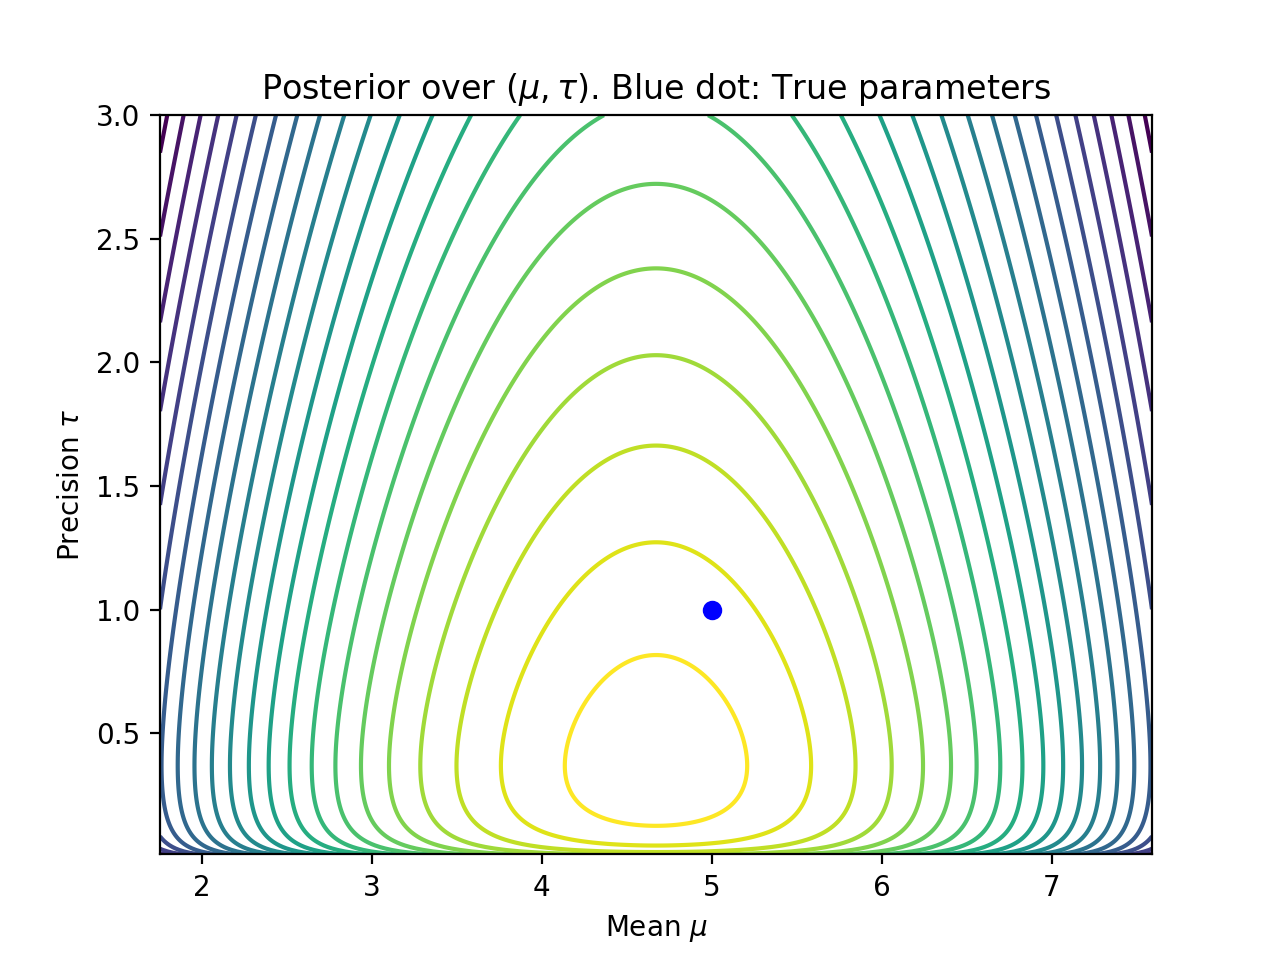

In [12]:
plot_posterior(q_nu, q_tau, q_alpha, q_beta, correct_mean, correct_precision)
plt.show()